In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
names_df = pd.read_csv("./sc.gene_program.names.csv", index_col=0)
program_dict = {
    '1': names_df['gene'][565:][20:][:-71][:115].tolist(),
    '2': names_df['gene'][565:][20:][:-71][115:176].tolist(),
    '3': names_df['gene'][565:][20:][:-71][176:219].tolist(),
    '4': names_df['gene'][565:][20:][:-71][219:244].tolist(),
    # '5': names_df['gene'][565:][20:][:-71][244:265].tolist(),
    '5': names_df['gene'][565:][20:][:-71][265:].tolist()
}

scdata = sc.read_h5ad('./RNA/sc.reclustered.h5')

In [3]:
score_df = pd.concat([pd.DataFrame(scdata[:, program_dict['1'] + program_dict['2'] + program_dict['3'] + program_dict['4'] + program_dict['5']].X.toarray(),
                                   index=scdata.obs_names,
                                   columns=program_dict['1'] + program_dict['2'] + program_dict['3'] + program_dict['4'] + program_dict['5']),
                                   scdata.obs['perturb_gene']], axis=1)
score_df = score_df[score_df['perturb_gene'] != 'Duplicate'].groupby('perturb_gene', as_index=False).mean().dropna().set_index('perturb_gene')
# print(score_df[program_dict['5']])
score_df = score_df.div(score_df.loc['sgNon-targeting', :], axis=1)
score_df.dropna(axis=1, inplace=True)

# Calculate program scores only for genes that exist in the data
for i in range(5):
    program_genes = [gene for gene in program_dict[str(i+1)] if gene in score_df.columns]
    if program_genes:
        score_df[f'Program {i+1}'] = score_df[program_genes].mean(axis=1)
        
score_df = score_df.drop(columns=[col for col in score_df.columns if col in program_dict['1'] + program_dict['2'] + program_dict['3'] + program_dict['4'] + program_dict['5']])
score_df = score_df.loc[score_df.index != 'sgNon-targeting']

/tmp/ipykernel_32275/446677686.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  score_df = score_df[score_df['perturb_gene'] != 'Duplicate'].groupby('perturb_gene', as_index=False).mean().dropna().set_index('perturb_gene')


In [4]:
chemokine_list = ["sgCcr1", "sgCcr2", "sgCcr4", "sgCcr5", "sgCcr6",
    "sgCcr7", "sgCcr10", "sgCxcr1", "sgCxcr2", "sgCxcr3", "sgCxcr4",
    "sgAckr3", "sgCxcr5", "sgCxcr6", "sgCd74", "sgGpr35"]
chemo_df = score_df.loc[chemokine_list]
tf_df = score_df.loc[~score_df.index.isin(chemokine_list)]
tf_df

,Program 1,Program 2,Program 3,Program 4,Program 5
perturb_gene,,,,,
sgBatf,0.575785,0.499629,0.345029,0.000000,1.418800
sgBcl2,1.137697,0.529931,0.898444,0.000000,1.042679
sgBcl2l11,1.041156,0.526794,0.768607,0.792170,0.843495
sgBhlhe40,0.892751,0.000000,1.099909,0.798836,1.196275
sgDdit4,0.803005,0.113218,1.208919,0.171074,1.151014
sgElob,1.777224,0.000000,1.591424,0.859475,0.928474
sgFos,0.955755,0.000000,1.080231,0.915156,1.162812
sgFoxp1,0.766097,0.000000,0.746143,0.470289,1.136825
sgHopx,1.021808,0.000000,0.896053,0.525366,1.036669


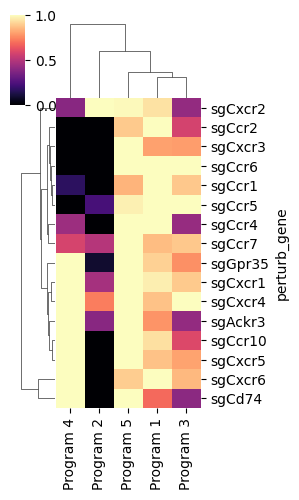

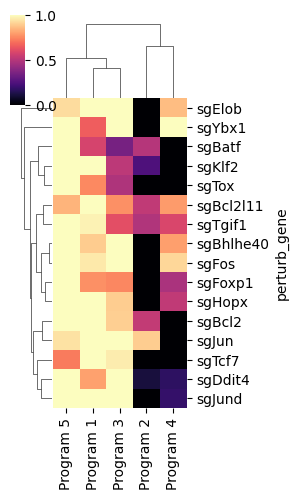

In [5]:
sns.clustermap(chemo_df, cmap='magma', vmax=1, vmin=0, figsize=(3, 5))
sns.clustermap(tf_df, cmap='magma', vmax=1, vmin=0, figsize=(3, 5))
plt.show()

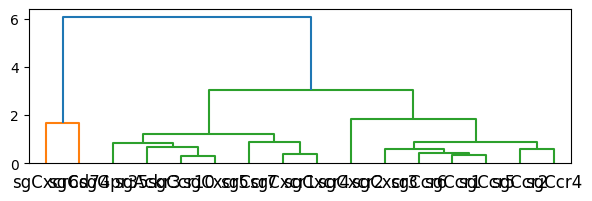

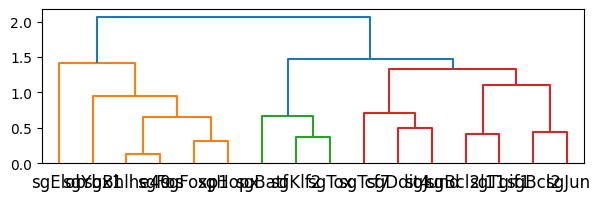

In [6]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(7, 2))
chem_linkage = sch.linkage(chemo_df.values, method='ward')
sch.dendrogram(chem_linkage, labels=chemo_df.index)

plt.figure(figsize=(7, 2))
tf_linkage = sch.linkage(tf_df.values, method='ward')
sch.dendrogram(tf_linkage, labels=tf_df.index)
plt.show()

/tmp/ipykernel_62530/1870806734.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf_df['Module'] = modules


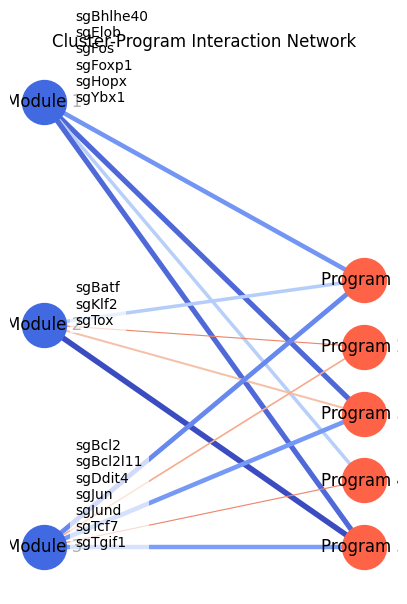

In [28]:
from scipy.cluster.hierarchy import fcluster
import networkx as nx

modules = fcluster(tf_linkage, 3, criterion='maxclust')

tf_df['Module'] = modules

module_means = tf_df.groupby('Module').mean()

module_guides = {}
for module in tf_df['Module'].unique():
    guides = tf_df[tf_df['Module'] == module].index.tolist()
    module_guides[module] = '\n'.join(guides)

melted_df = module_means.reset_index().melt(id_vars=['Module'], 
                                           var_name='Program',
                                           value_name='Score')
melted_df['Score'] = (melted_df['Score'] - melted_df['Score'].min()) / (melted_df['Score'].max() - melted_df['Score'].min())

plt.figure(figsize=(5, 7))
G = nx.Graph()

for module in melted_df['Module'].unique():
    G.add_node(f'Module {module}', node_type='module')
for program in melted_df['Program'].unique():
    G.add_node(program, node_type='program')

for _, row in melted_df.iterrows():
    if abs(row['Score']) > 0.01:
        G.add_edge(f'Module {row["Module"]}', 
                  row['Program'], 
                  weight=abs(row['Score']) * 2)

pos = {}
programs = [n for n,attr in G.nodes(data=True) if attr['node_type']=='program']
modules = [n for n,attr in G.nodes(data=True) if attr['node_type']=='module']

for i, program in enumerate(programs):
    pos[program] = (1, 0.2 - 0.6 * (i * 2/(len(programs)-1)))

for i, module in enumerate(modules):
    pos[module] = (-1, 1 - (i * 2/(len(modules)-1)))

nx.draw_networkx_nodes(G, pos,
                      nodelist=[n for n,attr in G.nodes(data=True) if attr['node_type']=='module'],
                      node_color='royalblue',
                      node_size=1000)
nx.draw_networkx_nodes(G, pos,
                      nodelist=[n for n,attr in G.nodes(data=True) if attr['node_type']=='program'],
                      node_color='tomato',
                      node_size=1000)

edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
edge_colors = plt.cm.coolwarm_r(np.array(weights) / max(weights))

edges = G.edges()
weights = [G[u][v]['weight'] * 2 for u,v in edges]
nx.draw_networkx_edges(G, pos, width=weights, edge_color=edge_colors)

nx.draw_networkx_labels(G, pos)

for module, guides in module_guides.items():
    module_pos = pos[f'Module {module}']
    plt.annotate(guides,
                xy=(module_pos[0], module_pos[1]),
                xytext=(module_pos[0] + 0.2, module_pos[1]),
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.title('Cluster-Program Interaction Network')
plt.axis('off')

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./plots/tf_module_program_network.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()


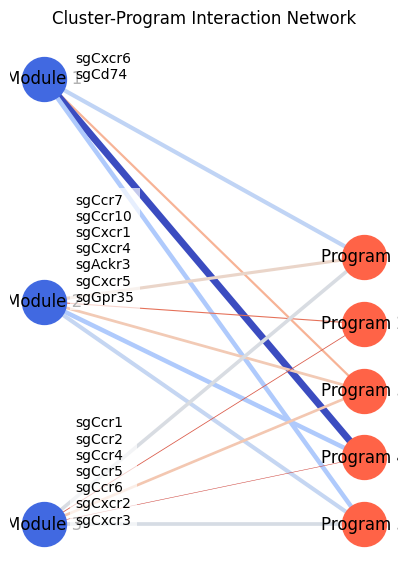

In [29]:
from scipy.cluster.hierarchy import fcluster
import networkx as nx

modules = fcluster(chem_linkage, 3, criterion='maxclust')

chemo_df['Module'] = modules

module_means = chemo_df.groupby('Module').mean()

module_guides = {}
for module in chemo_df['Module'].unique():
    guides = chemo_df[chemo_df['Module'] == module].index.tolist()
    module_guides[module] = '\n'.join(guides)

melted_df = module_means.reset_index().melt(id_vars=['Module'], 
                                           var_name='Program',
                                           value_name='Score')
melted_df['Score'] = (melted_df['Score'] - melted_df['Score'].min()) / (melted_df['Score'].max() - melted_df['Score'].min())
melted_df['Score'] = melted_df['Score'].map(lambda x: 0.5 if x > 0.5 else x)

plt.figure(figsize=(5, 7))
G = nx.Graph()

for module in melted_df['Module'].unique():
    G.add_node(f'Module {module}', node_type='module')
for program in melted_df['Program'].unique():
    G.add_node(program, node_type='program')

for _, row in melted_df.iterrows():
    if abs(row['Score']) > 0.01:
        G.add_edge(f'Module {row["Module"]}', 
                  row['Program'], 
                  weight=abs(row['Score']) * 2)

pos = {}
programs = [n for n,attr in G.nodes(data=True) if attr['node_type']=='program']
modules = [n for n,attr in G.nodes(data=True) if attr['node_type']=='module']

for i, program in enumerate(programs):
    pos[program] = (1, 0.2 - 0.6 * (i * 2/(len(programs)-1)))

for i, module in enumerate(modules):
    pos[module] = (-1, 1 - (i * 2/(len(modules)-1)))

nx.draw_networkx_nodes(G, pos,
                      nodelist=[n for n,attr in G.nodes(data=True) if attr['node_type']=='module'],
                      node_color='royalblue',
                      node_size=1000)
nx.draw_networkx_nodes(G, pos,
                      nodelist=[n for n,attr in G.nodes(data=True) if attr['node_type']=='program'],
                      node_color='tomato',
                      node_size=1000)

edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
edge_colors = plt.cm.coolwarm_r(np.array(weights) / max(weights))

edges = G.edges()
weights = [G[u][v]['weight'] * 5 for u,v in edges]
nx.draw_networkx_edges(G, pos, width=weights, edge_color=edge_colors)

nx.draw_networkx_labels(G, pos)

for module, guides in module_guides.items():
    module_pos = pos[f'Module {module}']
    plt.annotate(guides,
                xy=(module_pos[0], module_pos[1]),
                xytext=(module_pos[0] + 0.2, module_pos[1]),
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.title('Cluster-Program Interaction Network')
plt.axis('off')

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./plots/chemo_module_program_network.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

# TF ~ Chemokine network

In [ ]:
tf_df.index

In [8]:
from scipy.cluster.hierarchy import fcluster
modules = fcluster(tf_linkage, 3, criterion='maxclust')
tf_df['Module'] = modules

modules = fcluster(chem_linkage, 3, criterion='maxclust')
chemo_df['Module'] = modules

print(tf_df)
print(chemo_df)

              Program 1  Program 2  Program 3  Program 4  Program 5  Module
perturb_gene                                                               
sgBatf         0.575785   0.499629   0.345029   0.000000   1.418800       2
sgBcl2         1.137697   0.529931   0.898444   0.000000   1.042679       3
sgBcl2l11      1.041156   0.526794   0.768607   0.792170   0.843495       3
sgBhlhe40      0.892751   0.000000   1.099909   0.798836   1.196275       1
sgDdit4        0.803005   0.113218   1.208919   0.171074   1.151014       3
sgElob         1.777224   0.000000   1.591424   0.859475   0.928474       1
sgFos          0.955755   0.000000   1.080231   0.915156   1.162812       1
sgFoxp1        0.766097   0.000000   0.746143   0.470289   1.136825       1
sgHopx         1.021808   0.000000   0.896053   0.525366   1.036669       1
sgJun          1.013571   0.895826   1.093604   0.000000   0.940995       3
sgJund         1.183190   0.000000   1.473159   0.187042   1.024077       3
sgKlf2      

/tmp/ipykernel_62530/2832754383.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf_df['Module'] = modules


In [97]:
chemo_gene = chemo_df.index.str.lstrip('sg')
chemo_gene = chemo_gene[chemo_gene.isin(scdata.var_names)]

tf_gene = tf_df.index.str.lstrip('sg')
tf_gene = tf_gene[tf_gene.isin(scdata.var_names)]

chemo_tf_regdf = pd.concat([pd.DataFrame(scdata[:, chemo_gene].X.toarray(), index=scdata.obs_names, columns=chemo_gene),
                           scdata.obs['perturb_gene']], axis=1)
chemo_tf_regdf = chemo_tf_regdf[chemo_tf_regdf['perturb_gene'] != 'Duplicate'].groupby('perturb_gene', as_index=False).mean().dropna().set_index('perturb_gene')

tf_chemo_regdf = pd.concat([pd.DataFrame(scdata[:, tf_gene].X.toarray(), index=scdata.obs_names, columns=tf_gene),
                           scdata.obs['perturb_gene']], axis=1)
tf_chemo_regdf = tf_chemo_regdf[tf_chemo_regdf['perturb_gene'] != 'Duplicate'].groupby('perturb_gene', as_index=False).mean().dropna().set_index('perturb_gene')
for i in range(3):
    module_genes = tf_df.groupby('Module').get_group(i+1).index.str.lstrip('sg').tolist()
    module_genes = [gene for gene in module_genes if gene in tf_chemo_regdf.columns]
    tf_chemo_regdf[f'TF Module {i+1}'] = tf_chemo_regdf[module_genes].mean(axis=1)
tf_chemo_regdf = tf_chemo_regdf.drop(columns=[col for col in tf_chemo_regdf.columns if col in tf_gene])
for i in range(3):
    module_genes = chemo_df.groupby('Module').get_group(i+1).index.str.lstrip('sg').tolist()
    module_genes = [gene for gene in module_genes if gene in chemo_tf_regdf.columns]
    chemo_tf_regdf[f'Chemokine Module {i+1}'] = chemo_tf_regdf[module_genes].mean(axis=1)
chemo_tf_regdf = chemo_tf_regdf.drop(columns=[col for col in chemo_tf_regdf.columns if col in chemo_gene])

chemo_modules = chemo_df['Module'].to_dict()
tf_modules = tf_df['Module'].to_dict()
chemo_tf_regdf = pd.DataFrame({
    'Chemokine Module 1': chemo_tf_regdf.loc[[k for k,v in chemo_modules.items() if v==1], ].mean().tolist(),
    'Chemokine Module 2': chemo_tf_regdf.loc[[k for k,v in chemo_modules.items() if v==2], ].mean().tolist(), 
    'Chemokine Module 3': chemo_tf_regdf.loc[[k for k,v in chemo_modules.items() if v==3], ].mean().tolist()
}, index=['TF Module 1', 'TF Module 2', 'TF Module 3'])

tf_chemo_regdf = pd.DataFrame({
    'TF Module 1': tf_chemo_regdf.loc[[k for k,v in tf_modules.items() if v==1], ].mean().tolist(),
    'TF Module 2': tf_chemo_regdf.loc[[k for k,v in tf_modules.items() if v==2], ].mean().tolist(),
    'TF Module 3': tf_chemo_regdf.loc[[k for k,v in tf_modules.items() if v==3], ].mean().tolist()
}, index=['Chemokine Module 1', 'Chemokine Module 2', 'Chemokine Module 3'])

tf_chemo_regdf = tf_chemo_regdf.melt(ignore_index=False).reset_index()
chemo_tf_regdf = chemo_tf_regdf.melt(ignore_index=False).reset_index()

tf_chemo_regdf.columns = ['Chemokine Module', 'TF Module', 'Score']
chemo_tf_regdf.columns = ['TF Module', 'Chemokine Module', 'Score']

tf_chemo_regdf

/tmp/ipykernel_62530/3212491603.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chemo_tf_regdf = chemo_tf_regdf[chemo_tf_regdf['perturb_gene'] != 'Duplicate'].groupby('perturb_gene', as_index=False).mean().dropna().set_index('perturb_gene')
/tmp/ipykernel_62530/3212491603.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tf_chemo_regdf = tf_chemo_regdf[tf_chemo_regdf['perturb_gene'] != 'Duplicate'].groupby('perturb_gene', as_index=False).mean().dropna().set_index('perturb_gene')


,Chemokine Module,TF Module,Score
0,Chemokine Module 1,TF Module 1,0.977845
1,Chemokine Module 2,TF Module 1,0.303139
2,Chemokine Module 3,TF Module 1,0.592182
3,Chemokine Module 1,TF Module 2,1.007257
4,Chemokine Module 2,TF Module 2,0.367928
5,Chemokine Module 3,TF Module 2,0.580382
6,Chemokine Module 1,TF Module 3,1.007963
7,Chemokine Module 2,TF Module 3,0.358118
8,Chemokine Module 3,TF Module 3,0.628173


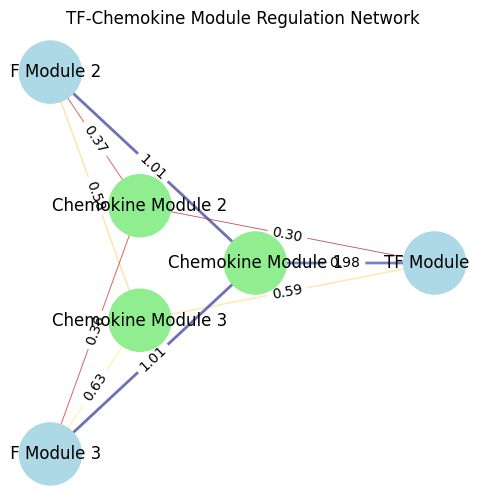

In [105]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# 创建有向图
G = nx.DiGraph()

# 添加节点
tf_modules = tf_chemo_regdf['TF Module'].unique()
chemo_modules = tf_chemo_regdf['Chemokine Module'].unique()

# 添加TF模块节点和Chemokine模块节点
for tf in tf_modules:
    G.add_node(tf, node_type='TF')
for chemo in chemo_modules:  
    G.add_node(chemo, node_type='Chemokine')

# 添加边和权重
for _, row in tf_chemo_regdf.iterrows():
    G.add_edge(row['TF Module'], row['Chemokine Module'], weight=row['Score'])

# 设置节点位置
# Chemokine模块位于等边三角形内部
r = 0.3  # 内圈半径
angles = np.linspace(0, 2*np.pi, len(chemo_modules), endpoint=False)
pos = {}
for i, chemo in enumerate(chemo_modules):
    pos[chemo] = (r * np.cos(angles[i]), r * np.sin(angles[i]))

# TF模块位于外部
R = 1.0  # 外圈半径
angles = np.linspace(0, 2*np.pi, len(tf_modules), endpoint=False)
for i, tf in enumerate(tf_modules):
    pos[tf] = (R * np.cos(angles[i]), R * np.sin(angles[i]))

# 绘图设置
plt.figure(figsize=(6, 6))

# 绘制节点
nx.draw_networkx_nodes(G, pos, 
                      node_color=['lightblue' if G.nodes[node]['node_type']=='TF' else 'lightgreen' for node in G.nodes],
                      node_size=2000)

# 绘制边
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
# 根据权重设置颜色
min_weight = min(weights)
max_weight = max(weights)
colors = [(w-min_weight)/(max_weight-min_weight) for w in weights]
edge_colors = plt.cm.RdYlBu(colors)

nx.draw_networkx_edges(G, pos, width=[w*2 for w in weights], 
                      edge_color=edge_colors, alpha=0.7)

# 添加标签
nx.draw_networkx_labels(G, pos)

# 添加边的权重标签
edge_labels = nx.get_edge_attributes(G, 'weight')
edge_labels = {k: f'{v:.2f}' for k,v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title('TF-Chemokine Module Regulation Network')
plt.axis('off')
plt.show()